In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=3 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 3.000e+00   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 27786 
    Total predicted counts          : 28337.76
    Total off counts                : 101971.00

    Total background counts         : 20394.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 500
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 2.69 s, sys: 35.3 ms, total: 2.72 s
Wall time: 2.76 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 28089 
    Total predicted counts          : 28333.76
    Total off counts                : 101951.00

    Total background counts         : 20390.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 27989 
    Total predicted counts          : 28399.36
    Total off counts                : 102279.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_15 

    Total counts                    : 28088 
    Total predicted counts          : 28232.56
    Total off counts                : 101445.00

    Total background counts         : 20289.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_16 

    Total counts                    : 28149 
    Total predicted counts          : 28138.16
    Total off counts                : 100973.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_39 

    Total counts                    : 28418 
    Total predicted counts          : 28262.36
    Total off counts                : 101594.00

    Total background counts         : 20318.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_40 

    Total counts                    : 28335 
    Total predicted counts          : 28200.36
    Total off counts                : 101284.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_60 

    Total counts                    : 28016 
    Total predicted counts          : 28250.96
    Total off counts                : 101537.00

    Total background counts         : 20307.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_61 

    Total counts                    : 28560 
    Total predicted counts          : 28379.56
    Total off counts                : 102180.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_86 

    Total counts                    : 28179 
    Total predicted counts          : 28214.56
    Total off counts                : 101355.00

    Total background counts         : 20271.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_87 

    Total counts                    : 28332 
    Total predicted counts          : 28302.56
    Total off counts                : 101795.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_107 

    Total counts                    : 28216 
    Total predicted counts          : 28389.36
    Total off counts                : 102229.00

    Total background counts         : 20445.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_108 

    Total counts                    : 28298 
    Total predicted counts          : 28329.96
    Total off counts                : 101932.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_131 

    Total counts                    : 28285 
    Total predicted counts          : 28331.56
    Total off counts                : 101940.00

    Total background counts         : 20388.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_132 

    Total counts                    : 28408 
    Total predicted counts          : 28307.36
    Total off counts                : 101819.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_153 

    Total counts                    : 28196 
    Total predicted counts          : 28207.96
    Total off counts                : 101322.00

    Total background counts         : 20264.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_154 

    Total counts                    : 28587 
    Total predicted counts          : 28288.96
    Total off counts                : 101727.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_174 

    Total counts                    : 28130 
    Total predicted counts          : 28287.76
    Total off counts                : 101721.00

    Total background counts         : 20344.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_175 

    Total counts                    : 28477 
    Total predicted counts          : 28337.96
    Total off counts                : 101972.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_198 

    Total counts                    : 28047 
    Total predicted counts          : 28213.16
    Total off counts                : 101348.00

    Total background counts         : 20269.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_199 

    Total counts                    : 28209 
    Total predicted counts          : 28297.36
    Total off counts                : 101769.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_216 

    Total counts                    : 28258 
    Total predicted counts          : 28182.36
    Total off counts                : 101194.00

    Total background counts         : 20238.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_217 

    Total counts                    : 28106 
    Total predicted counts          : 28257.96
    Total off counts                : 101572.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_237 

    Total counts                    : 28061 
    Total predicted counts          : 28208.36
    Total off counts                : 101324.00

    Total background counts         : 20264.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_238 

    Total counts                    : 28141 
    Total predicted counts          : 28272.56
    Total off counts                : 101645.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_258 

    Total counts                    : 28080 
    Total predicted counts          : 28233.76
    Total off counts                : 101451.00

    Total background counts         : 20290.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_259 

    Total counts                    : 28293 
    Total predicted counts          : 28356.16
    Total off counts                : 102063.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_282 

    Total counts                    : 28106 
    Total predicted counts          : 28262.16
    Total off counts                : 101593.00

    Total background counts         : 20318.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_283 

    Total counts                    : 28317 
    Total predicted counts          : 28172.56
    Total off counts                : 101145.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_308 

    Total counts                    : 28248 
    Total predicted counts          : 28106.76
    Total off counts                : 100816.00

    Total background counts         : 20163.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_309 

    Total counts                    : 28508 
    Total predicted counts          : 28369.56
    Total off counts                : 102130.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_328 

    Total counts                    : 28233 
    Total predicted counts          : 28187.36
    Total off counts                : 101219.00

    Total background counts         : 20243.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_329 

    Total counts                    : 28165 
    Total predicted counts          : 28328.16
    Total off counts                : 101923.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_353 

    Total counts                    : 28038 
    Total predicted counts          : 28387.36
    Total off counts                : 102219.00

    Total background counts         : 20443.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_354 

    Total counts                    : 28216 
    Total predicted counts          : 28262.96
    Total off counts                : 101597.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_375 

    Total counts                    : 27930 
    Total predicted counts          : 28327.16
    Total off counts                : 101918.00

    Total background counts         : 20383.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_376 

    Total counts                    : 28275 
    Total predicted counts          : 28286.76
    Total off counts                : 101716.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_394 

    Total counts                    : 27963 
    Total predicted counts          : 28226.36
    Total off counts                : 101414.00

    Total background counts         : 20282.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_395 

    Total counts                    : 28089 
    Total predicted counts          : 28205.76
    Total off counts                : 101311.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_414 

    Total counts                    : 28239 
    Total predicted counts          : 28305.36
    Total off counts                : 101809.00

    Total background counts         : 20361.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_415 

    Total counts                    : 28110 
    Total predicted counts          : 28258.96
    Total off counts                : 101577.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_439 

    Total counts                    : 28240 
    Total predicted counts          : 28234.36
    Total off counts                : 101454.00

    Total background counts         : 20290.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_440 

    Total counts                    : 28261 
    Total predicted counts          : 28283.36
    Total off counts                : 101699.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_464 

    Total counts                    : 28147 
    Total predicted counts          : 28259.16
    Total off counts                : 101578.00

    Total background counts         : 20315.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_465 

    Total counts                    : 28404 
    Total predicted counts          : 28325.56
    Total off counts                : 101910.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_489 

    Total counts                    : 28356 
    Total predicted counts          : 28261.56
    Total off counts                : 101590.00

    Total background counts         : 20318.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_490 

    Total counts                    : 28342 
    Total predicted counts          : 28107.56
    Total off counts                : 100820.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

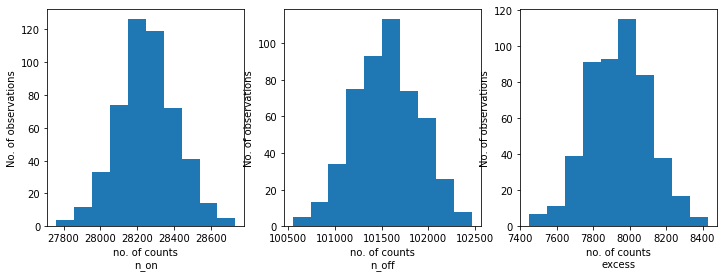

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 2min 8s, sys: 692 ms, total: 2min 9s
Wall time: 2min 10s


In [15]:
results

[{'index': 2.08918040012255,
  'amplitude': 1.850177104819134e-12,
  'lambda_': 3.673352294360042},
 {'index': 2.246807419011836,
  'amplitude': 1.1098591702415119e-12,
  'lambda_': 2.7334017535608637},
 {'index': 2.106780651085318,
  'amplitude': 1.8190278475372278e-12,
  'lambda_': 3.589715644696545},
 {'index': 2.18563790614877,
  'amplitude': 1.4182434701104837e-12,
  'lambda_': 3.2199238719446983},
 {'index': 2.2335082148813235,
  'amplitude': 1.3108606151084685e-12,
  'lambda_': 3.0577825796166618},
 {'index': 2.2509457037855745,
  'amplitude': 1.1846104974806104e-12,
  'lambda_': 2.89042551828439},
 {'index': 2.3602379548752186,
  'amplitude': 8.955689341049595e-13,
  'lambda_': 2.5390207352432648},
 {'index': 2.0765373734656976,
  'amplitude': 1.9857797497104225e-12,
  'lambda_': 3.76726993622788},
 {'index': 2.2878256000698376,
  'amplitude': 1.0410776552645376e-12,
  'lambda_': 2.7678322508808515},
 {'index': 2.283895763951333,
  'amplitude': 1.0408090689897587e-12,
  'lambda

index: 2.2113559092045914 += 0.08209196705592067


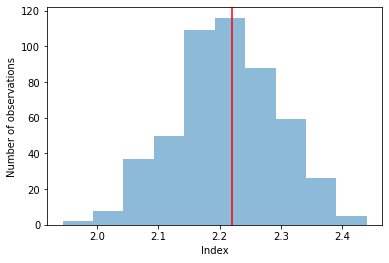

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.3586205289026581e-12 += 3.325012470314825e-13


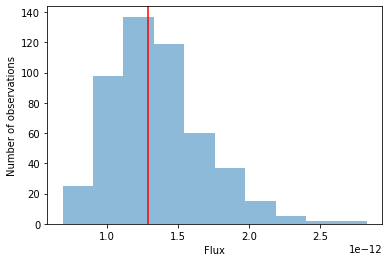

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 3.039753821286851 += 0.41865022758912035


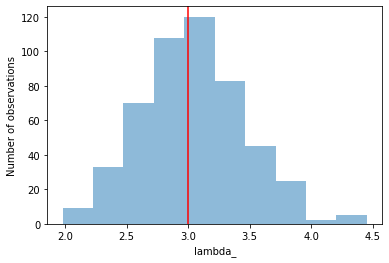

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")